<a href="https://colab.research.google.com/github/o7s8r6/CVIVAAN/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

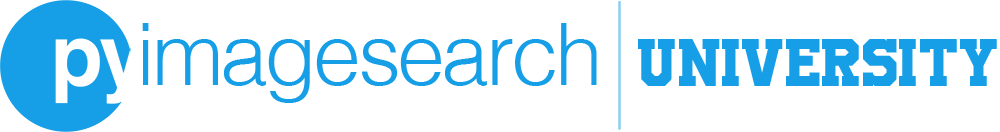

# Automatic Differentiation Part 2: Implementation Using Micrograd
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Automatic Differentiation Part 2: Implementation Using Micrograd](https://pyimg.co/ra6ow)  blog post published on 2022-12-26.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*PyImageSearch Team*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2022 OptiReto, LLC and PyImageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

## Blog Post Code

### Imports and Setup

In [ ]:
import math
import random
from typing import List, Tuple, Union
from matplotlib import pyplot as plt

### The `Value` class


In [ ]:
class Value(object):
    """
    We need to wrap the raw data into a class that will store the
    metadata to help in automatic differentiation.

    Attributes:
        data (float): The data for the Value node.
        _children (Tuple): The children of the current node.
    """

    def __init__(self, data: float, _children: Tuple = ()):
        # The raw data for the Value node.
        self.data = data

        # The partial gradient of the last node with respect to this
        # node. This is also termed as the global gradient.
        # Gradient 0.0 means that there is no effect of the change
        # of the last node with respect to this node. On
        # initialization it is assumed that all the variables have no
        # effect on the entire architecture.
        self.grad = 0.0

        # The function that derives the gradient of the children nodes
        # of the current node. It is easier this way, because each node
        # is built from children nodes and an operation. Upon back-propagation
        # the current node can easily fill in the gradients of the children.
        # Note: The global gradient is the multiplication of the local gradient
        # and the flowing gradient from the parent.
        self._backward = lambda: None

        # Define the children of this node.
        self._prev = set(_children)

    def __repr__(self):
        # This is the string representation of the Value node.
        return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
# Build a Value node
raw_data = 5.0
print(f"Raw Data(data={raw_data}, type={type(raw_data)}")
value_node = Value(data=raw_data)

# Calling the `__repr__` function here
print(value_node)

### Addition

In [ ]:
def custom_addition(self, other: Union["Value", float]) -> "Value":
    """
    The addition operation for the Value class.
    Args:
        other (Union["Value", float]): The other value to add to this one.
    Usage:
        >>> x = Value(2)
        >>> y = Value(3)
        >>> z = x + y
        >>> z.data
        5
    """
    # If the other value is not a Value, then we need to wrap it.
    other = other if isinstance(other, Value) else Value(other)

    # Create a new Value node that will be the output of the addition.
    out = Value(data=self.data + other.data, _children=(self, other))

    def _backward():
        # Local gradient:
        # x = a + b
        # dx/da = 1
        # dx/db = 1
        # Global gradient with chain rule:
        # dy/da = dy/dx . dx/da = dy/dx . 1
        # dy/db = dy/dx . dx/db = dy/dx . 1
        self.grad += out.grad * 1.0
        other.grad += out.grad * 1.0

    # Set the backward function on the output node.
    out._backward = _backward
    return out

def custom_reverse_addition(self, other):
    """
    Reverse addition operation for the Value class.
    Args:
        other (float): The other value to add to this one.
    Usage:
        >>> x = Value(2)
        >>> y = Value(3)
        >>> z = y + x
        >>> z.data
        5
    """
    # This is the same as adding. We can reuse the __add__ method.
    return self + other


Value.__add__ = custom_addition
Value.__radd__ = custom_reverse_addition

In [ ]:
# Build a and b
a = Value(data=5.0)
b = Value(data=6.0)

# Print the addition
print(f"{a} + {b} => {a+b}")

In [ ]:
# Add a and b
c = a + b

# Assign a global gradient to c
c.grad = 11.0
print(f"c => {c}")

# Now apply `_backward` to c
c._backward()
print(f"a => {a}")
print(f"b => {b}")

> Note that the global gradient of $c$ is routed to $a$ and $b$.

### Multiplication

In [ ]:
def custom_multiplication(self, other: Union["Value", float]) -> "Value":
    """
    The multiplication operation for the Value class.
    Args:
        other (float): The other value to multiply to this one.
    Usage:
        >>> x = Value(2)
        >>> y = Value(3)
        >>> z = x * y
        >>> z.data
        6
    """
    # If the other value is not a Value, then we need to wrap it.
    other = other if isinstance(other, Value) else Value(other)

    # Create a new Value node that will be the output of
    # the multiplication.
    out = Value(data=self.data * other.data, _children=(self, other))

    def _backward():
        # Local gradient:
        # x = a * b
        # dx/da = b
        # dx/db = a
        # Global gradient with chain rule:
        # dy/da = dy/dx . dx/da = dy/dx . b
        # dy/db = dy/dx . dx/db = dy/dx . a
        self.grad += out.grad * other.data
        other.grad += out.grad * self.data

    # Set the backward function on the output node.
    out._backward = _backward
    return out

def custom_reverse_multiplication(self, other):
    """
    Reverse multiplication operation for the Value class.
    Args:
        other (float): The other value to multiply to this one.
    Usage:
        >>> x = Value(2)
        >>> y = Value(3)
        >>> z = y * x
        >>> z.data
        6
    """
    # This is the same as multiplying. We can reuse the __mul__ method.
    return self * other


Value.__mul__ = custom_multiplication
Value.__rmul__ = custom_reverse_multiplication

In [ ]:
# Build a and b
a = Value(data=5.0)
b = Value(data=6.0)

# Print the multiplication
print(f"{a} * {b} => {a*b}")

In [ ]:
# Multiply a and b
c = a * b

# Assign a global gradient to c
c.grad = 11.0
print(f"c => {c}")

# Now apply `_backward` to c
c._backward()
print(f"a => {a}")
print(f"b => {b}")

### Power

In [ ]:
def custom_power(self, other):
    """
    The power operation for the Value class.
    Args:
        other (float): The other value to raise this one to.
    Usage:
        >>> x = Value(2)
        >>> z = x ** 2.0
        >>> z.data
        4
    """
    assert isinstance(
        other, (int, float)
    ), "only supporting int/float powers for now"

    # Create a new Value node that will be the output of the power.
    out = Value(data=self.data ** other, _children=(self,))

    def _backward():
        # Local gradient:
        # x = a ** b
        # dx/da = b * a ** (b - 1)
        # Global gradient:
        # dy/da = dy/dx . dx/da = dy/dx . b * a ** (b - 1)
        self.grad += out.grad * (other * self.data ** (other - 1))

    # Set the backward function on the output node.
    out._backward = _backward
    return out


Value.__pow__ = custom_power

In [ ]:
# Build a
a = Value(data=5.0)
# For power operation we will use
# the raw data and not wrap it into
# a node. This is done for simplicity.
b = 2.0

# Print the power operation
print(f"{a} ** {b} => {a**b}")

In [ ]:
# Raise a to the power of b
c = a ** b

# Assign a global gradient to c
c.grad = 11.0
print(f"c => {c}")

# Now apply `_backward` to c
c._backward()
print(f"a => {a}")
print(f"b => {b}")

### Negation

In [ ]:
def custom_negation(self):
    """
    Negation operation for the Value class.
    Usage:
        >>> x = Value(2)
        >>> z = -x
        >>> z.data
        -2
    """
    # This is the same as multiplying by -1. We can reuse the
    # __mul__ method.
    return self * -1

Value.__neg__ = custom_negation

In [ ]:
# Build `a`
a = Value(data=5.0)

# Print the negation
print(f"Negation of {a} => {(-a)}")

In [ ]:
# Negate a
c = -a

# Assign a global gradient to c
c.grad = 11.0
print(f"c => {c}")

# Now apply `_backward` to c
c._backward()
print(f"a => {a}")

### Subtraction

In [ ]:
def custom_subtraction(self, other):
    """
    Subtraction operation for the Value class.
    Args:
        other (float): The other value to subtract to this one.
    Usage:
        >>> x = Value(2)
        >>> y = Value(3)
        >>> z = x - y
        >>> z.data
        -1
    """
    # This is the same as adding the negative of the other value.
    # We can reuse the __add__ and the __neg__ methods.
    return self + (-other)

def custom_reverse_subtraction(self, other):
    """
    Reverse subtraction operation for the Value class.
    Args:
        other (float): The other value to subtract to this one.
    Usage:
        >>> x = Value(2)
        >>> y = Value(3)
        >>> z = y - x
        >>> z.data
        1
    """
    # This is the same as subtracting. We can reuse the __sub__ method.
    return other + (-self)


Value.__sub__ = custom_subtraction
Value.__rsub__ = custom_reverse_subtraction

In [ ]:
# Build a and b
a = Value(data=5.0)
b = Value(data=4.0)

# Print the negation
print(f"{a} - {b} => {(a-b)}")

In [ ]:
# Subtract b from a
c = a - b

# Assign a global gradient to c
c.grad = 11.0
print(f"c => {c}")

# Now apply `_backward` to c
c._backward()
print(f"a => {a}")
print(f"b => {b}")

### Division

In [ ]:
def custom_division(self, other):
    """
    Division operation for the Value class.
    Args:
        other (float): The other value to divide to this one.
    Usage:
        >>> x = Value(10)
        >>> y = Value(5)
        >>> z = x / y
        >>> z.data
        2
    """
    # Use the __pow__ method to implement division.
    return self * other ** -1

def custom_reverse_division(self, other):
    """
    Reverse division operation for the Value class.
    Args:
        other (float): The other value to divide to this one.
    Usage:
        >>> x = Value(10)
        >>> y = Value(5)
        >>> z = y / x
        >>> z.data
        0.5
    """
    # Use the __pow__ method to implement division.
    return other * self ** -1


Value.__truediv__ = custom_division
Value.__rtruediv__ = custom_reverse_division

In [ ]:
# Build a and b
a = Value(data=6.0)
b = Value(data=3.0)

# Print the negation
print(f"{a} / {b} => {(a/b)}")

In [ ]:
# Divide a with b
c = a / b

# Assign a global gradient to c
c.grad = 11.0
print(f"c => {c}")

# Now apply `_backward` to c
c._backward()
print(f"a => {a}")
print(f"b => {b}")

> With division we see a same problem with gradient flow as we had seen with subtraction. Have you figured out the problem yet? 

### <font color="yellow">Re</font>ctified <font color="yellow">L</font>inear <font color="yellow">U</font>nit

In [ ]:
def relu(self):
    """
    The relu activation function.
    Usage:
        >>> x = Value(-2)
        >>> y = x.relu()
        >>> y.data
        0
    """
    out = Value(data=0 if self.data < 0 else self.data, _children=(self,))

    def _backward():
        # Local gradient:
        # x = relu(a)
        # dx/da = 0 if a < 0 else 1
        # Global gradient:
        # dy/da = dy/dx . dx/da = dy/dx . (0 if a < 0 else 1)
        self.grad += out.grad * (out.data > 0)

    # Set the backward function on the output node.
    out._backward = _backward
    return out


Value.relu = relu

In [ ]:
# Build a
a = Value(data=6.0)

# Print a and the negation
print(f"ReLU ({a}) => {(a.relu())}")
print(f"ReLU (-{a}) => {((-a).relu())}")

In [ ]:
# Build a and b
a = Value(3.0)
b = Value(-3.0)

# Apply relu on both the nodes
relu_a = a.relu()
relu_b = b.relu()

# Assign a global gradients
relu_a.grad = 11.0
relu_b.grad = 11.0

# Now apply `_backward`
relu_a._backward()
print(f"a => {a}")
relu_b._backward()
print(f"b => {b}")

### The global backward method

In [ ]:
def backward(self):
    """
    The backward pass of the backward propagation algorithm.
    Usage:
        >>> x = Value(2)
        >>> y = Value(3)
        >>> z = x * y
        >>> z.backward()
        >>> x.grad
        3
        >>> y.grad
        2
    """
    # Build an empty list which will hold the
    # topologically sorted graph
    topo = []

    # Build a set of all the visited nodes
    visited = set()

    # A closure to help build the topologically sorted graph
    def build_topo(node: "Value"):
        if node not in visited:
            # If node is not visited add the node to the
            # visited set.
            visited.add(node)

            # Iterate over the children of the node that
            # is being visited
            for child in node._prev:
                # Apply recursion to build the topologically sorted
                # graph of the children
                build_topo(child)
            
            # Only append node to the topologically sorted list
            # if all its children are visited.
            topo.append(node)

    # Call the `build_topo` method on self
    build_topo(self)

    # Go one node at a time and apply the chain rule
    # to get its gradient
    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

Value.backward = backward

In [ ]:
# Now create an expression that uses a lot of
# primitive operations
a = Value(2.0)
b = Value(3.0)

c = a+b

d = 4.0
e = c**d

f = Value(6.0)
g = e/f

print("BEFORE backward")
for element in [a, b, c, d, e, f, g]:
    print(element)

# Backward on the final node will backprop
# the gradients through the entire DAG
g.backward()

print("\nAFTER backward")
for element in [a, b, c, d, e, f, g]:
    print(element)

In [ ]:
# Solve the problem with subtraction
a = Value(data=6.0)
b = Value(data=3.0)

c = a - b
c.backward()
print(f"c => {c}")
print(f"a => {a}")
print(f"b => {b}")

In [ ]:
# Solve the problem with division
a = Value(data=6.0)
b = Value(data=3.0)

c = a / b
c.backward()
print(f"c => {c}")
print(f"a => {a}")
print(f"b => {b}")

### Build a Multilayer Perceptron with `micrograd`

#### Module

In [ ]:
class Module(object):
    """
    The parent class for all neural network modules.
    """

    def zero_grad(self):
        # Zero out the gradients of all parameters.
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        # Initialize a parameters function that all the children will
        # override and return a list of parameters.
        return []

#### Neuron

In [ ]:
class Neuron(Module):
    """
    A single neuron.
    Parameters:
        number_inputs (int): number of inputs
        is_nonlinear (bool): whether to apply ReLU nonlinearity
        name (int): the index of neuron
    """

    def __init__(self, number_inputs: int, name, is_nonlinear: bool = True):
        # Create weights for the neuron. The weights are initialized
        # from a random uniform distribution.
        self.weights = [Value(data=random.uniform(-1, 1)) for _ in range(number_inputs)]

        # Create bias for the neuron.
        self.bias = Value(data=0.0)
        self.is_nonlinear = is_nonlinear

        self.name = name

    def __call__(self, x: List["Value"]) -> "Value":
        # Compute the dot product of the input and the weights. Add the
        # bias to the dot product.
        act = sum(
            ((wi * xi) for wi, xi in zip(self.weights, x)),
            self.bias
        )

        # If activation is mentioned apply ReLU to it.
        return act.relu() if self.is_nonlinear else act

    def parameters(self):
        # Get the parameters of the neuron. The parameters of a neuron
        # is its weights and bias.
        return self.weights + [self.bias]

    def __repr__(self):
        # Print a better representation of the neuron.
        return f"Neuron {self.name}(Number={len(self.weights)}, Non-Linearity={'ReLU' if self.is_nonlinear else 'None'})"

In [ ]:
x = [2.0, 3.0]
neuron = Neuron(number_inputs=2, name=1)
print(neuron)
out = neuron(x)
print(f"Output => {out}")

#### Layer

In [ ]:
class Layer(Module):
    """
    A layer of neurons.
    Parameters:
        number_inputs (int): number of inputs
        number_outputs (int): number of outputs
        name (int): index of the layer
    """

    def __init__(self, number_inputs: int, number_outputs: int, name: int, **kwargs):
        # A layer is a list of neurons.
        self.neurons = [
            Neuron(number_inputs=number_inputs, name=idx, **kwargs) for idx in range(
                number_outputs)
        ]
        self.name = name
        self.number_outputs = number_outputs

    def __call__(self, x: List["Value"]) -> Union[List["Value"], "Value"]:
        # Iterate over all the neurons and compute the output of each.
        out = [n(x) for n in self.neurons]
        return out if self.number_outputs != 1 else out[0]

    def parameters(self):
        # The parameters of a layer is the parameters of all the neurons.
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        # Print a better representation of the layer.
        layer_str = "\n".join(f'    - {str(n)}' for n in self.neurons)
        return f"Layer {self.name} \n{layer_str}\n"

In [ ]:
x = [2.0, 3.0]
layer = Layer(number_inputs=2, number_outputs=3, name=1)
print(layer)
out = layer(x)
print(f"Output => {out}")

In [ ]:
x = [2.0, 3.0]
layer = Layer(number_inputs=2, number_outputs=1, name=1)
print(layer)
out = layer(x)
print(f"Output => {out}")

#### Multilayer Perceptron

In [ ]:
class MLP(Module):
    """
    The Multi-Layer Perceptron (MLP) class.
    Parameters:
        number_inputs (int): number of inputs.
        list_number_outputs (List[int]): number of outputs in each layer.
    """

    def __init__(self, number_inputs: int, list_number_outputs: List[int]):
        # Get the number of inputs and all the number of outputs in
        # a single list.
        total_size = [number_inputs] + list_number_outputs

        # Build layers by connecting each layer to the previous one.
        self.layers = [
            # Do not use non linearity in the last layer.
            Layer(
                number_inputs=total_size[i],
                number_outputs=total_size[i + 1],
                name=i,
                is_nonlinear=i != len(list_number_outputs) - 1
            )
            for i in range(len(list_number_outputs))
        ]

    def __call__(self, x: List["Value"]) -> List["Value"]:
        # Iterate over the layers and compute the output of
        # each sequentially.
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        # Get the parameters of the MLP
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        # Print a better representation of the MLP.
        mlp_str = "\n".join(f'  - {str(layer)}' for layer in self.layers)
        return f"MLP of \n{mlp_str}"

In [ ]:
x = [2.0, 3.0]
mlp = MLP(number_inputs=2, list_number_outputs=[3, 3, 1])
print(mlp)
out = mlp(x)
print(f"Output => {out}")

#### Train the MLP

In [ ]:
# Build a dataset
xs = [
    [0.5, 0.5, 0.70],
    [0.4, -0.1, 0.5],
    [-0.2, -0.75, 1.0],
]
ys = [0.0, 1.0, 0.0]

# Build an MLP
mlp = MLP(number_inputs=3, list_number_outputs=[3, 3, 1])

In [ ]:
def forward(mlp: "MLP", xs: List[List[float]]) -> List["Value"]:
    # Get the predictions upon forwarding the input data through
    # the mlp
    ypred = [mlp(x) for x in xs]
    return ypred

def compute_loss(ys: List[int], ypred: List["Value"]) -> "Value":
    # Obtain the L2 distance of the prediction and ground truths
    loss = sum(
        [(ygt - yout)**2 for ygt, yout in zip(ys, ypred)]
    )
    return loss

def update_mlp(mlp: "MLP"):
    # Iterate over all the layers of the MLP
    for layer in mlp.layers:
        # Iterate over all the neurons of each layer
        for neuron in layer.neurons:
            # Iterate over all the weights of each neuron
            for weight in neuron.weights:
                # Update the data of the weight with the 
                # gradient information.
                weight.data -= (1e-2 * weight.grad)
            # Update the data of the bias with the 
            # gradient information.
            neuron.bias.data -= (1e-2 * neuron.bias.grad)

In [ ]:
# Define the epochs for which we want to run the training process.
epochs = 50

# Define a loss list to help log the loss.
loss_list = []

# Iterate each epoch and train the model.
for idx in range(epochs):
    # Step 1: Forward the inputs to the mlp and get the predictions
    ypred = forward(mlp, xs)
    # Step 2: Compute Loss between the predictions and the ground truths
    loss = compute_loss(ys, ypred)
    # Step 3: Ground the gradients. These accumulate which is not desired.
    mlp.zero_grad()
    # Step 4: Backpropagate the gradients through the entire architecture
    loss.backward()
    # Step 5: Update the mlp
    update_mlp(mlp)
    # Step 6: Log the loss
    loss_list.append(loss.data)
    print(f"Epoch {idx}: Loss {loss.data: 0.2f}")

In [ ]:
# Plot the loss
plt.plot(loss_list)
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
# Inference
pred = mlp(xs[0])
ygt = ys[0]

print(f"Prediction => {pred.data: 0.2f}")
print(f"Ground Truth => {ygt: 0.2f}")

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Automatic Differentiation Part 2: Implementation Using Micrograd*](https://pyimg.co/ra6ow) published on 2022-12-26.

# Code License Agreement
```
Copyright (c) 2022 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from OptiReto, LLC and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```